Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
from tensorflow.keras import layers, models
from glob import glob
import shutil

import Augmentor
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
warnings.filterwarnings('ignore', category=FutureWarning)
tf.get_logger().setLevel('ERROR')

In [2]:
epochs = 50

# Defining the path for train and test images
data_dir_train = Path('C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train')
data_dir_test = Path('C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\test')

batch_size = 32
img_height = 180
img_width = 180

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
# Defined in the 2nd block of the code

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                 # Path to training data directory
    seed=123,                       # Random seed for reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=32,                  # Define batch size
    label_mode='categorical',       # Use 'categorical' for multiclass classification
    validation_split=0.2,           # Reserve 20% for validation
    subset='training'               # Specify that this is the training subset
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                 # Path to training data directory
    seed=123,                       # Random seed for reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=32,                  # Define batch size
    label_mode='categorical',       # Use 'categorical' for multiclass classification
    validation_split=0.2,           # Reserve 20% for validation
    subset='validation'             # Specify that this is the validation subset
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

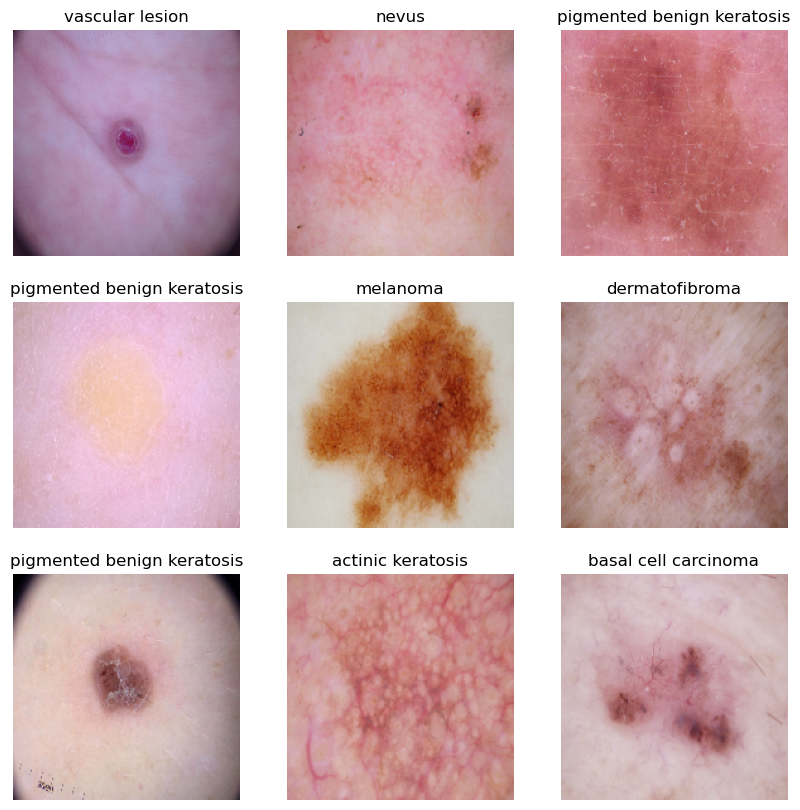

In [8]:
### your code goes here, you can use training or validation data to visualize

class_names = train_ds.class_names  # Get class names from the dataset

# Take a batch of images and labels from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch from the training data
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the image to uint8 for display
        plt.title(class_names[tf.argmax(labels[i])])  # Get class name using the label
        plt.axis("off")
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
### Your code goes here

# Define the CNN model
# Create the CNN model
model = models.Sequential([
      
    # Normalization layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling Layer
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer with Batch Normalization and Dropout
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  # Batch Normalization before Dropout
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary to review the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,841 (503.29 KB)

 Trainable params: 128,137 (500.54 KB)

 Non-trainable params: 704 (2.75 KB)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [11]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [12]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 980ms/step - accuracy: 0.3515 - loss: 1.9294 - val_accuracy: 0.1499 - val_loss: 2.1655
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4695 - loss: 1.4553 - val_accuracy: 0.1499 - val_loss: 2.2057
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 975ms/step - accuracy: 0.5072 - loss: 1.3976 - val_accuracy: 0.1499 - val_loss: 2.6136
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 990ms/step - accuracy: 0.4942 - loss: 1.3423 - val_accuracy: 0.1678 - val_loss: 3.0345
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5483 - loss: 1.2660 - val_accuracy: 0.1633 - val_loss: 3.7584
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 991ms/step - accuracy: 0.5559 - loss: 1.2277 - val_accuracy: 0.1723 - val_loss: 3.4395
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5788 - loss: 1.1682 - val_accuracy: 0.2528 - val_loss: 2.6451
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 54s 971ms/step - accuracy: 0.5974 - loss: 1.1333 - val_accuracy: 0.3

In [13]:
best_epoch = np.argmax(history.history['val_accuracy'])

# Get the corresponding training and validation accuracy at the best epoch
best_val_accuracy = history.history['val_accuracy'][best_epoch]
best_train_accuracy = history.history['accuracy'][best_epoch]

# Print the details of the best epoch
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy: {best_train_accuracy:.4f}")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")

Best Epoch: 50
Training Accuracy: 0.9833
Validation Accuracy: 0.5638


### Visualizing training results

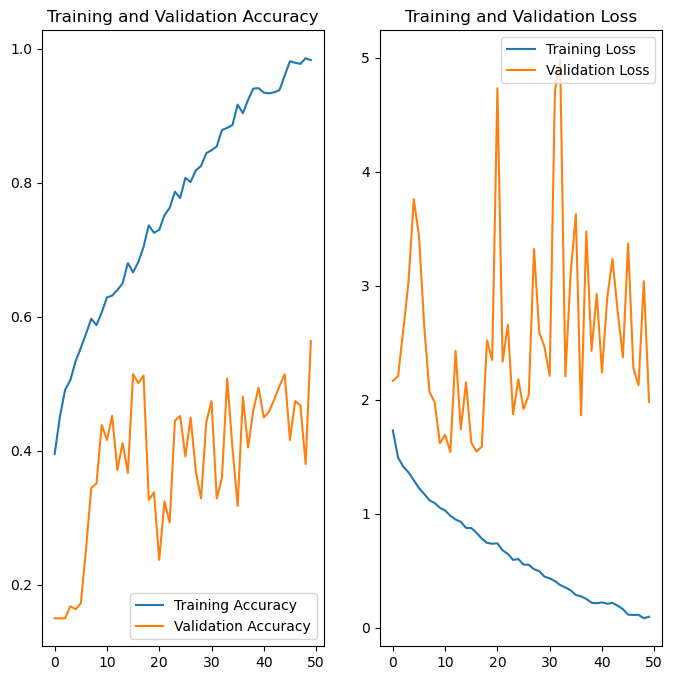

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
best_epoch = np.argmax(history.history['val_accuracy'])

# Get the corresponding training and validation accuracy at the best epoch
best_val_accuracy = history.history['val_accuracy'][best_epoch]
best_train_accuracy = history.history['accuracy'][best_epoch]

# Print the details of the best epoch
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy: {best_train_accuracy:.4f}")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")

Best Epoch: 50
Training Accuracy: 0.9833
Validation Accuracy: 0.5638


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Best Epoch: 50
Training Accuracy: 0.9833
Validation Accuracy: 0.5638

The model clearly overfits as there's a huge gap between the training and the validation accuracy.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', input_shape=(img_height, img_width, 3)),  # Input shape defined here
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
])

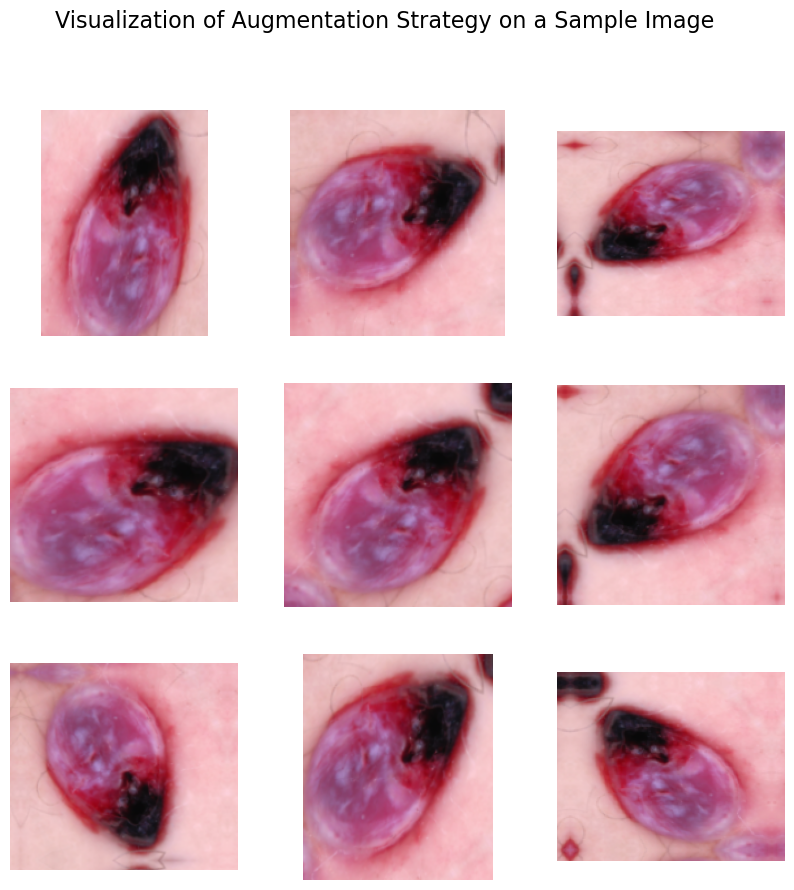

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Get one batch of images from the training dataset
for images, labels in train_ds.take(1):
    sample_image = images[0]  # Take the first image from the batch

# Set up the plot
plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 augmented versions of the image
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))  # Apply augmentation
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))  # Convert image back to uint8 for display
    plt.axis("off")
plt.suptitle("Visualization of Augmentation Strategy on a Sample Image", fontsize=16)
plt.show()


### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# Define the CNN model with data augmentation, rescaling, and dropout
model = models.Sequential([
    # Data augmentation
    data_augmentation,
    
    # Normalization layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout after pooling

    # Second Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout after pooling

    # Third Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout after pooling

    # Global Average Pooling Layer
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer with Batch Normalization and Dropout
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  # Batch Normalization before Dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout after activation

    # Output Layer
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])


### Compiling the model

In [19]:
## Your code goes here

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary to review the architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,841 (503.29 KB)

 Trainable params: 128,137 (500.54 KB)

 Non-trainable params: 704 (2.75 KB)

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
# Assuming train_ds and val_ds are already defined datasets for training and validation
history = model.fit(
    train_ds,                  # Training dataset
    validation_data = val_ds,  # Validation dataset
    epochs = epochs,           # Train for 50 epochs
    verbose = 1                # Display progress during training
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.2812 - loss: 2.1016 - val_accuracy: 0.1499 - val_loss: 2.1360
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 993ms/step - accuracy: 0.3712 - loss: 1.7243 - val_accuracy: 0.1499 - val_loss: 2.2310
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.3786 - loss: 1.7231 - val_accuracy: 0.1499 - val_loss: 2.3424
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4075 - loss: 1.6257 - val_accuracy: 0.1499 - val_loss: 2.6005
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4340 - loss: 1.5604 - val_accuracy: 0.1857 - val_loss: 2.5281
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4854 - loss: 1.4570 - val_accuracy: 0.1521 - val_loss: 2.4863
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4720 - loss: 1.4171 - val_accuracy: 0.1902 - val_loss: 2.7445
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4771 - loss: 1.4086 - val_accuracy: 0.2416 - val_lo

### Visualizing the results

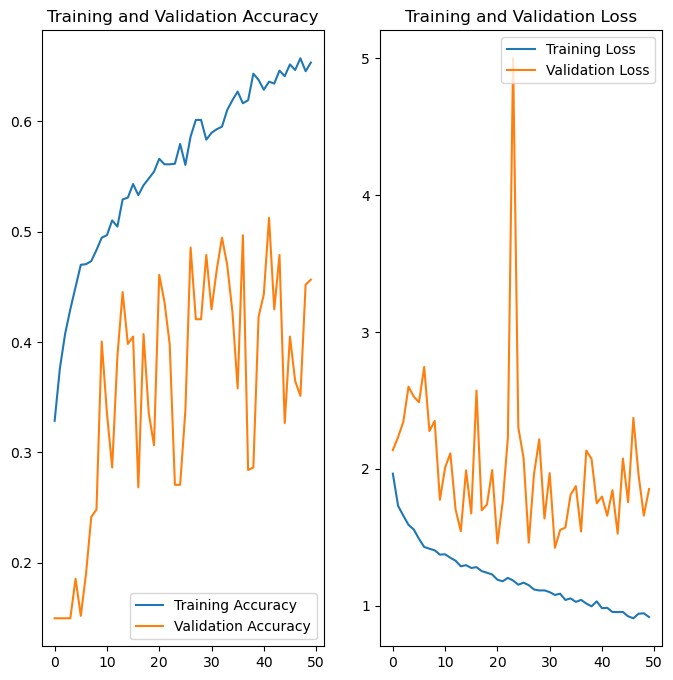

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

accuracy: 0.6495 - val_accuracy: 0.4564
The model still overfits, but there's a significant improvement as the difference has gone down significantly. The training accuracy has gone down as well, but we can try and improve on the overall accuracy once the overfitting is addressed.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

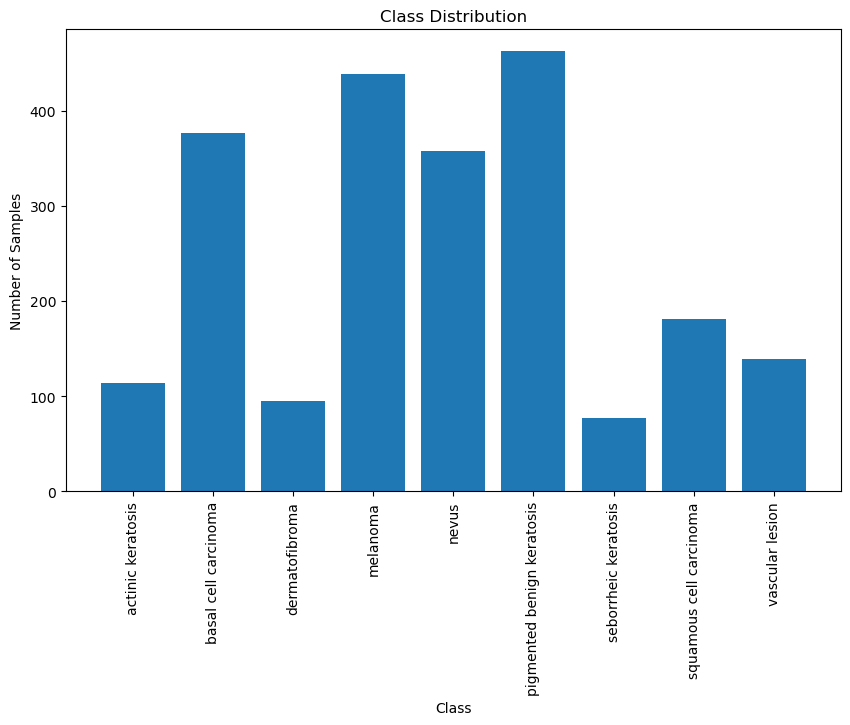

In [22]:
# Define the path to your training directory
data_dir_train = Path('C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train')

# Get the list of class names (subdirectories in data_dir_train)
class_names = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

# Calculate the number of images in each class directory
num_samples = {class_name: len(os.listdir(os.path.join(data_dir_train, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(num_samples.keys(), num_samples.values())
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


#### **Todo:** Write your findings here: 

#### - Which class has the least number of samples?
Seborrheic Keratosis has the least no of sample.

#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented Benign Keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
# Iterate over class names and augment images
for class_name in class_names:
    class_path = data_dir_train / class_name  # Use / to concatenate paths
    p = Augmentor.Pipeline(str(class_path))  # Convert Path object to string
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Add 500 samples per class


Initialised with 114 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FC4CBC6BF0>: 100%|██████████| 500/500 [00:04<00:00, 113.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FC767D06A0>: 100%|██████████| 500/500 [00:04<00:00, 118.16 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FC70E44250>: 100%|██████████| 500/500 [00:04<00:00, 124.60 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1FE1BE9E290>: 100%|██████████| 500/500 [00:20<00:00, 24.75 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FCBC1FA6B0>: 100%|██████████| 500/500 [00:17<00:00, 28.84 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FC4CBC74C0>: 100%|██████████| 500/500 [00:04<00:00, 118.94 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1FCBC1FA890>: 100%|██████████| 500/500 [00:09<00:00, 54.55 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FC5F416800>: 100%|██████████| 500/500 [00:04<00:00, 113.86 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\Vinay Joshi\Documents\PGD AI\4. Convolutional Neural Networks\Melanoma Detection Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FC4CAFFE80>: 100%|██████████| 500/500 [00:04<00:00, 120.79 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob  # Import glob to use it for file pattern matching

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0490e2ee-d872-458e-b2dd-842ca386e2ee.jpg',
 'C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_071bf9dc-2d9c-4413-a9d0-ab7c47f0f342.jpg',
 'C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4564313b-5ea4-4e9e-9e6d-568d09d4601d.jpg',
 'C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural N

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
# Collect paths of augmented images (assuming they are stored in 'output' folders within class directories)
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Extract lesion (class) names based on the folder structure
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(path))) for path in path_list_new]

# Create the dictionary mapping paths to lesion names
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

# Print a sample to verify
print(list(dataframe_dict_new.items())[:5])  # Display first 5 items


[('C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0490e2ee-d872-458e-b2dd-842ca386e2ee.jpg', 'actinic keratosis'), ('C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_071bf9dc-2d9c-4413-a9d0-ab7c47f0f342.jpg', 'actinic keratosis'), ('C:\\Users\\Vinay Joshi\\Documents\\PGD AI\\4. Convolutional Neural Networks\\Melanoma Detection Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4564313b-5ea4-4e9e-9e6d-568d09d4601d.jpg', 'actinic keratosis'), ('C

In [29]:
# Create original_df from the initial dataset (excluding augmented images)
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(path)) for path in path_list_original]

# Create the original DataFrame
original_df = pd.DataFrame(list(zip(path_list_original, lesion_list_original)), columns=['Path', 'Label'])

# Create df2 from augmented data (assuming dataframe_dict_new has been defined as in the previous steps)
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Append df2 to original_df
new_df = original_df.append(df2, ignore_index=True)

# Print a sample of the new DataFrame
print(new_df.head())

                                                Path              Label
0  C:\Users\Vinay Joshi\Documents\PGD AI\4. Convo...  actinic keratosis
1  C:\Users\Vinay Joshi\Documents\PGD AI\4. Convo...  actinic keratosis
2  C:\Users\Vinay Joshi\Documents\PGD AI\4. Convo...  actinic keratosis
3  C:\Users\Vinay Joshi\Documents\PGD AI\4. Convo...  actinic keratosis
4  C:\Users\Vinay Joshi\Documents\PGD AI\4. Convo...  actinic keratosis


In [30]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
#Moving the generated images to the parent folder of the class

# Loop through each class folder in the train directory
class_folders = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

for class_name in class_folders:
    class_path = os.path.join(data_dir_train, class_name)
    output_folder = os.path.join(class_path, 'output')  # Path to the output folder

    if os.path.exists(output_folder):
        # Move all images from the output folder to the class folder
        for image_file in glob(os.path.join(output_folder, '*.jpg')):
            shutil.move(image_file, class_path)  # Move files to the parent class folder

        # Optionally, remove the output folder if it's now empty
        if not os.listdir(output_folder):
            os.rmdir(output_folder)

print("All augmented images moved to parent class folders.")

All augmented images moved to parent class folders.


In [ ]:
# Get the list of class names (subdirectories in data_dir_train)
class_names = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

# Calculate the number of images in each class directory
num_samples = {class_name: len(os.listdir(os.path.join(data_dir_train, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(num_samples.keys(), num_samples.values())
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


#### **Todo:** Create a training dataset

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,   # 20% of the data will be used for validation
    subset='training',      # Use 'training' to get the training subset
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,       # 20% of the data will be used for validation
    subset='validation',        # Use 'validation' to get the validation subset
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [34]:
## your code goes here

# Create the CNN model
# Create the CNN model
model = models.Sequential([
    # Data augmentation
    data_augmentation,
    
    # Normalization layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout after pooling

    # Second Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout after pooling

    # Third Convolutional Block with Batch Normalization and Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout after pooling

    # Global Average Pooling Layer
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer with Batch Normalization and Dropout
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  # Batch Normalization before Dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout after activation

    # Output Layer
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if using one-hot encoding for labels
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,841 (503.29 KB)

 Trainable params: 128,137 (500.54 KB)

 Non-trainable params: 704 (2.75 KB)

#### **Todo:**  Train your model

In [36]:
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,                # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs,           # Number of epochs
    verbose=1                # Show progress during training
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 164s 945ms/step - accuracy: 0.2352 - loss: 2.1814 - val_accuracy: 0.1128 - val_loss: 2.4699
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 165s 977ms/step - accuracy: 0.3653 - loss: 1.7086 - val_accuracy: 0.1344 - val_loss: 2.5538
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 156s 926ms/step - accuracy: 0.3924 - loss: 1.6091 - val_accuracy: 0.2390 - val_loss: 2.1824
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 163s 962ms/step - accuracy: 0.4156 - loss: 1.5418 - val_accuracy: 0.2643 - val_loss: 2.4350
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 156s 926ms/step - accuracy: 0.4295 - loss: 1.4892 - val_accuracy: 0.2910 - val_loss: 1.9012
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 156s 924ms/step - accuracy: 0.4467 - loss: 1.4215 - val_accuracy: 0.3563 - val_loss: 1.7921
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 160s 947ms/step - accuracy: 0.4598 - loss: 1.4222 - val_accuracy: 0.3541 - val_loss: 1.9045
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 161s 955ms/step - accuracy: 0.4637 -

169/169 ━━━━━━━━━━━━━━━━━━━━ 156s 922ms/step - accuracy: 0.6849 - loss: 0.8101 - val_accuracy: 0.5174 - val_loss: 1.3793


#### **Todo:**  Visualize the model results

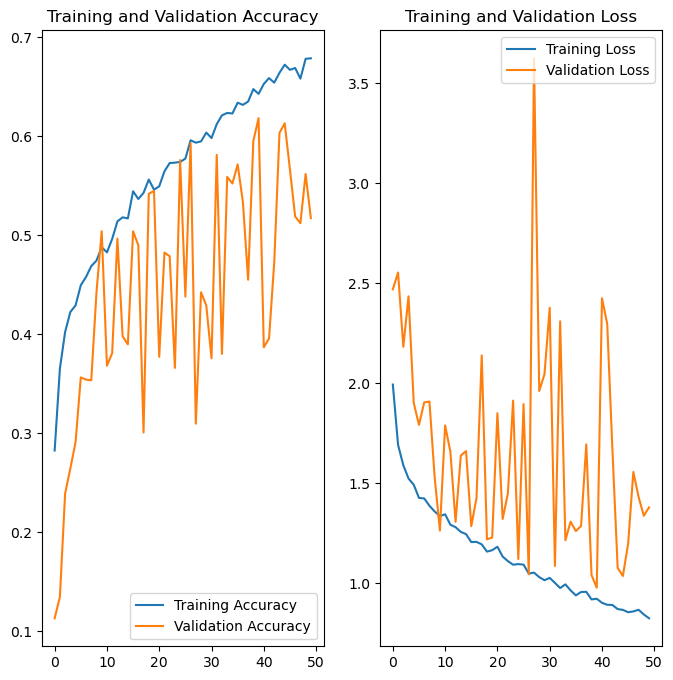

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
best_epoch = np.argmax(history.history['val_accuracy'])

# Get the corresponding training and validation accuracy at the best epoch
best_val_accuracy = history.history['val_accuracy'][best_epoch]
best_train_accuracy = history.history['accuracy'][best_epoch]

# Print the details of the best epoch
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy: {best_train_accuracy:.4f}")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")

Best Epoch: 40
Training Accuracy: 0.6430
Validation Accuracy: 0.6184


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes, overfitting is revoled to a large extent. Class rebalance helped. Although, I would love to work on the model and improve it further, the time it takes to execute the code is limitting my ability to experiment with different parameters.

In [39]:
# Define the path to the test dataset directory

# Create a test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Typically, we do not shuffle the test set
)


Found 118 files belonging to 9 classes.


In [40]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test accuracy and loss
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.3955 - loss: 2.6452
Test Accuracy: 0.3898
Test Loss: 2.8081
